In [3]:
from random import seed
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

seed(12345)
np.random.seed(12345)
sns.set_theme()

In [34]:
#Generador de datos para mediciones
TAM_DATOS = []

def procesar_archivo(ruta):
    with open(ruta, 'r', encoding="UTF-8") as archivo:
        cadenas = []
        for palabra in archivo:
            cadenas.append(palabra.strip())
            
        return cadenas

cadenas = {}
cs = procesar_archivo("prueba_palabras_mucha_amplitudv2.txt")
palabras = set(procesar_archivo("palabras_con_mucha_amplitudv2.txt"))
for c in cs:
    if not len(c) in cadenas:
        cadenas[len(c)] = c
        TAM_DATOS.append(len(c))
TAM_DATOS.sort()
print(cadenas)

{45: 'wytbdjvqvtqslctldxrwwjelxyssewrysjelxyssewrys', 55: 'nuoeranmuxbgyjnwwfiyiehwkhrwhmdvhiwytbdjvqvtqslctldxrww', 60: 'jelxyssewrysjelxyssewrysjelxyssewrysjelxyssewrysjelxyssewrys', 70: 'nuoeranmuxbgyjnwwfiyiehwkhrwhmdvhijelxyssewrysjelxyssewrysjelxyssewrys', 75: 'wytbdjvqvtqslctldxrwwwytbdjvqvtqslctldxrwwwytbdjvqvtqslctldxrwwjelxyssewrys', 80: 'ppxdttfpbiwlsqjrutpgollhnopfynqeepyvymolojrgjryxtjaifdqzjelxyssewrysjelxyssewrys', 90: 'jelxyssewrysotbizxuzhfplauycjdzttjyybqbejqcvtiyxcavbgeybbhvwwkcpunldpwytbdjvqvtqslctldxrww', 100: 'nuoeranmuxbgyjnwwfiyiehwkhrwhmdvhijelxyssewrysjelxyssewryswytbdjvqvtqslctldxrwwwytbdjvqvtqslctldxrww', 125: 'ppxdttfpbiwlsqjrutpgollhnopfynqeepyvymolojrgjryxtjaifdqzwytbdjvqvtqslctldxrwwjelxyssewrysjelxyssewrysjelxyssewrysjelxyssewrys', 150: 'ppxdttfpbiwlsqjrutpgollhnopfynqeepyvymolojrgjryxtjaifdqznuoeranmuxbgyjnwwfiyiehwkhrwhmdvhijelxyssewrysjelxyssewrysjelxyssewrysjelxyssewrysjelxyssewrys', 175: 'hvlcqptazemrcevjxifzxyavyuelseuqsytqytorzyfjbkzfnbuqrfvbtbvf

In [4]:
#Utils para medicion de tiempos
from concurrent.futures import ProcessPoolExecutor, as_completed
import time
import os
# Este parámetro controla cuantas veces se ejecuta el algoritmo para cada
# tamaño. Esto es conveniente para reducir el error estadístico en la medición
# de tiempos. Al finalizar las ejecuciones, se promedian los tiempos obtenidos
RUNS_PER_SIZE = 5

# Ajustar este valor si se quiere usar más de un proceso para medir los tiempos
# de ejecución, o None para usar todos los procesadores disponibles. Si se usan
# varios procesos, tener cuidado con el uso de memoria del sistema.
MAX_WORKERS = max(1, (os.cpu_count() or 0) // 4)

def _time_run(algorithm, *args):
    start = time.time()
    algorithm(*args)
    return time.time() - start


def time_algorithm(algorithm, sizes, get_args):
    futures = {}
    total_times = {i: 0 for i in sizes}

    # Usa un ProcessPoolExecutor para ejecutar las mediciones en paralelo
    # (el ThreadPoolExecutor no sirve por el GIL de Python)
    with ProcessPoolExecutor(MAX_WORKERS) as p:
        for i in sizes:
            for _ in range(RUNS_PER_SIZE):
                futures[p.submit(_time_run, algorithm, *get_args(i))] = i

        for f in as_completed(futures):
            result = f.result()
            i = futures[f]
            total_times[i] += result

    return {s: t / RUNS_PER_SIZE for s, t in total_times.items()}

In [5]:
#Funcion largos extremos
def buscar_largos_extremos(palabras): # O(k), k = cantidad total de palabras
    min, max = float('inf'), 0

    for palabra in palabras:
        if len(palabra) < min:
            min = len(palabra)
        if len(palabra) > max:
            max = len(palabra)
    
    return min, max

In [6]:
#Algoritmo usado en tp2.py
MSG_NO_ES = "No es un mensaje"

def validar_mensaje(cadena, palabras, largo_min = None, largo_max = None): # nlong?
    if len(cadena) == 0:
        return ""

    validacion = [None] * len(cadena)

    if largo_min is None or largo_max is None:
        largo_min, largo_max = buscar_largos_extremos(palabras)

    for ini in range(len(cadena)):
        for i in range(ini + largo_min - 1, min(ini + largo_max, len(cadena))):
            fin = i + 1

            if validacion[i] is None:
                if cadena[ini:fin] in palabras and (ini == 0 or validacion[ini - 1] is not None):
                    validacion[i] = ini

        if validacion[-1] is not None: # Ya encontré palabras para la totalidad de la cadena.
            break

    return validacion
"""
    if validacion[-1] is None:
        return MSG_NO_ES

    return reconstruir_mensaje(validacion, cadena)
"""

def reconstruir_mensaje(validacion, cadena): # O(n), n = largo de la cadena oiginal
    i = len(validacion) - 1
    palabras = []

    while i >= 0:
        palabras.append(cadena[validacion[i] : i + 1])
        i = validacion[i] - 1
    
    return " ".join(palabras[::-1])

In [7]:
##Algoritmo usado en tp2.py sin optimizaciones
def validar_mensaje_matriz(cadena, palabras): # O(n^3)
    if len(cadena) == 0:
        return ""
    matriz = [[False for _ in range(len(cadena))] for _ in range(len(cadena))]

    for i in range(len(cadena)):
        for j in range(i, len(cadena)):
            if matriz[i - 1][j]:
                matriz[i][j] = True

            palabra = cadena[i : j + 1]
            if palabra in palabras and (i == 0 or matriz[i - 1][i - 1]):
                matriz[i][j] = True

    return matriz[i][j]
"""
    if matriz[-1][-1] == False:
        return MSG_NO_ES

    return reconstruir_mensaje_matriz(matriz, cadena)
"""

def reconstruir_mensaje_matriz(matriz, cadena): # O(n)
    mensaje = []
    i, j = len(matriz) - 1, len(matriz[0]) - 1

    while i >= 0:
        if i > 0 and matriz[i][j] == matriz[i - 1][j]:
            i -= 1
            continue
        palabra = cadena[i : j + 1]
        mensaje.append(palabra)
        i, j = i - 1, i - 1
    
    return " ".join(mensaje[::-1])

In [8]:
# largo_min, largo_max = buscar_largos_extremos(palabras)
def get_args(size):
    return cadenas[size], palabras

In [35]:
#Generador de resultados para las mediciones del algoritmo
x = np.array(TAM_DATOS)
results = time_algorithm(validar_mensaje, x, get_args)

In [36]:
#Funciones a usar para las mediciones y aproximaciones dadas por la catedra
f_n = lambda x, c1, c2: c1 * x + c2
f_nlogn = lambda x, c1, c2: c1 * x * np.log(x) + c2 
f_n2 = lambda x, c1, c2: c1 * x**2 + c2
f_n3 = lambda x, c1, c2: c1 * x**3 + c2

c_n, _ = sp.optimize.curve_fit(f_n, x, [results[n] for n in x])
c_nlogn, _ = sp.optimize.curve_fit(f_nlogn, x, [results[n] for n in x])
c_n2, _ = sp.optimize.curve_fit(f_n2, x, [results[n] for n in x])
c_n3, _ = sp.optimize.curve_fit(f_n3, x, [results[n] for n in x])

In [37]:
#Imprime los resultados de las mediciones en el formato dado
for k, v in results.items():
    print(f"Largo: {k}, tiempo: {v}\n")

Largo: 45, tiempo: 0.00011477470397949218

Largo: 55, tiempo: 0.00014719963073730468

Largo: 60, tiempo: 0.0001778125762939453

Largo: 70, tiempo: 0.00021543502807617188

Largo: 75, tiempo: 0.00027141571044921877

Largo: 80, tiempo: 0.00025830268859863283

Largo: 90, tiempo: 0.00036640167236328124

Largo: 100, tiempo: 0.0004123210906982422

Largo: 125, tiempo: 0.0006839275360107422

Largo: 150, tiempo: 0.0011028289794921876

Largo: 175, tiempo: 0.0013185977935791016

Largo: 200, tiempo: 0.0017172336578369141

Largo: 225, tiempo: 0.0022555828094482423

Largo: 250, tiempo: 0.002784585952758789

Largo: 275, tiempo: 0.0036136627197265623

Largo: 300, tiempo: 0.004576873779296875

Largo: 325, tiempo: 0.005773735046386719

Largo: 350, tiempo: 0.00707554817199707

Largo: 375, tiempo: 0.007689142227172851

Largo: 400, tiempo: 0.009345531463623047

Largo: 425, tiempo: 0.011104440689086914

Largo: 450, tiempo: 0.012259435653686524

Largo: 475, tiempo: 0.014148092269897461

Largo: 500, tiempo: 0.

In [38]:
#Imprime la suma de los tiempos promedio
print(f"Suma de los tiempos promedio: ",sum(results.values()))

Suma de los tiempos promedio:  279.69060053825376


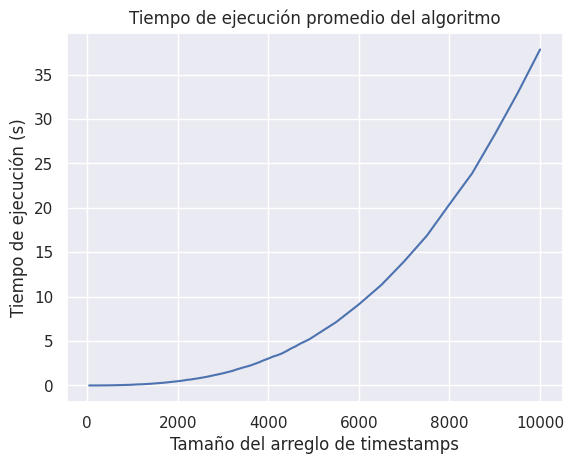

In [39]:

#Crea el grafico del algoritmo por cantidad de elementos en funcion del tiempo (s)
ax: plt.Axes
fig, ax = plt.subplots()
ax.plot(x, [results[i] for i in x], label="Medición")
ax.set_title('Tiempo de ejecución promedio del algoritmo')
ax.set_xlabel('Tamaño del arreglo de timestamps')
ax.set_ylabel('Tiempo de ejecución (s)')
None


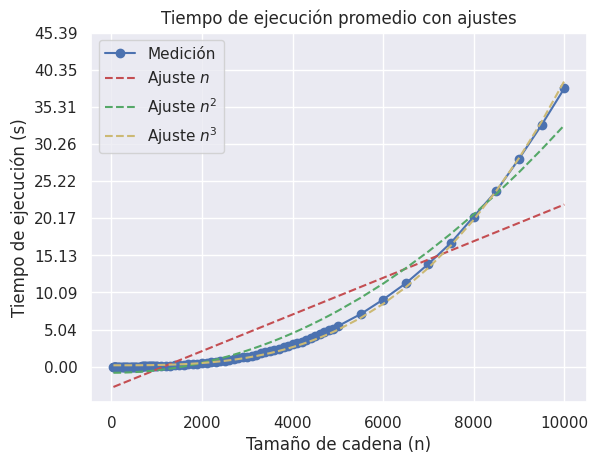

In [42]:
#Crea un grafico como el anterior incluyendo el ajuste a la funcion cuadratica y la lineal logaritmica
ax: plt.Axes
fig, ax = plt.subplots()
ax.plot(x, [results[n] for n in x], "bo-", label="Medición")
ax.plot(x, [f_n(n, c_n[0], c_n[1]) for n in x], 'r--', label="Ajuste $n$")
#ax.plot(x, [f_nlogn(n, c_nlogn[0], c_nlogn[1]) for n in x], 'r--', label="Ajuste $n log(n)$")
ax.plot(x, [f_n2(n, c_n2[0], c_n2[1]) for n in x], 'g--', label="Ajuste $n^2$")
ax.plot(x, [f_n3(n, c_n3[0], c_n3[1]) for n in x], "y--", label="Ajuste $n^3$")
ax.set_yticks(np.linspace(0, max(results.values()) * 1.2, 10))
ax.set_title('Tiempo de ejecución promedio con ajustes')
ax.set_xlabel('Tamaño de cadena (n)')
ax.set_ylabel('Tiempo de ejecución (s)')
ax.legend()
None

Error cuadrático total para n^3: 6.790984805668033


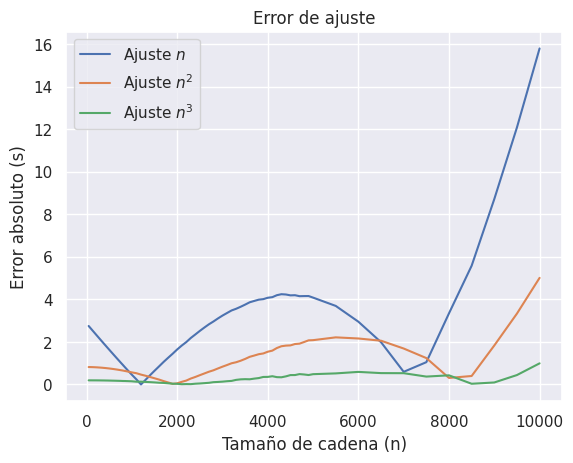

In [44]:
#Crea un grafico que muestra el error de ajuste que hay con la cuadratica y la lineal logaritmica
errors_n2 = [np.abs(c_n2[0] * n**2 + c_n2[1] - results[n]) for n in x]
#errors_nlogn = [np.abs(c_nlogn[0] * n * np.log(n) + c_nlogn[1] - results[n]) for n in x]
errors_n3 = [np.abs(c_n3[0] * n**3 + c_n3[1] - results[n] ) for n in x]
errors_n = [np.abs(c_n[0] * n + c_n[1] - results[n]) for n in x]
print(f"Error cuadrático total para n^3: {np.sum(np.power(errors_n3, 2))}")

ax: plt.Axes
fig, ax = plt.subplots()
ax.plot(x, errors_n, label="Ajuste $n$")
ax.plot(x, errors_n2, label="Ajuste $n^2$")
#ax.plot(x, errors_nlogn, label="Ajuste $n \log(n)$")
ax.plot(x, errors_n3, label="Ajuste $n^3$")
ax.set_title('Error de ajuste')
ax.set_xlabel('Tamaño de cadena (n)')
ax.set_ylabel('Error absoluto (s)')
ax.legend()
None

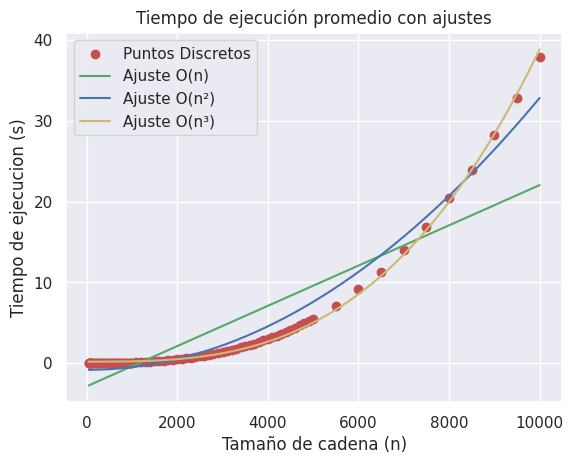

In [45]:
#Crea un grafico de la medicion con puntos discretos parecido al visto anteriormente

x_fit = np.linspace(min(x), max(x), 1000)
y_n = f_n(x_fit, *c_n)
y_n2 = f_n2(x_fit, *c_n2)
y_n3 = f_n3(x_fit, *c_n3)

plt.figure()
plt.scatter(x, [results[n] for n in x], color='r', label='Puntos Discretos', marker='o')
plt.plot(x_fit, y_n, color='g', label='Ajuste O(n)')
plt.plot(x_fit, y_n2, color='b', label='Ajuste O(n²)')
plt.plot(x_fit, y_n3, color='y', label='Ajuste O(n³)')

plt.title('Tiempo de ejecución promedio con ajustes')
plt.xlabel('Tamaño de cadena (n)')
plt.ylabel('Tiempo de ejecucion (s)')
plt.legend()
plt.grid(True)
plt.show()